In [ ]:

# todo plotar distrib de qtd de palavras e plotar pra ver o número bom de cortar dps de limpar

import pandas as pd
import numpy as np
from sys import getsizeof
import os
import re
import tensorflow as tf
import transformers
import nltk.tokenize
import string
import nltk
from nltk.corpus import stopwords

#from autocorrect import Speller 
# https://github.com/filyp/autocorrect https://towardsdatascience.com/cleaning-preprocessing-text-data-by-building-nlp-pipeline-853148add68a
%matplotlib inline

In [3]:
df = pd.read_csv(f"../data/transformed/comments.csv")
# Drop Date
df = df.drop("dateISO", axis=1)


In [4]:
df.columns
# Change types
df["loja"] = pd.Categorical(df["loja"])
df["score"] = pd.to_numeric(df["score"], downcast="integer")
df["date"] = pd.to_numeric(df["date"], downcast="integer")
# Drop NA
df = df.loc[df["comment"].isna() == False]
# Tamanho do comentário
df["comment_size"] = pd.to_numeric(df["comment"].apply(len), downcast="integer")
df.info()
df.describe().T


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1199942 entries, 0 to 1199999
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype   
---  ------        --------------    -----   
 0   id_           1199942 non-null  object  
 1   id_user       1199942 non-null  object  
 2   comment       1199942 non-null  object  
 3   score         1199942 non-null  int8    
 4   date          1199942 non-null  int64   
 5   loja          1199942 non-null  category
 6   comment_size  1199942 non-null  int16   
dtypes: category(1), int16(1), int64(1), int8(1), object(3)
memory usage: 50.4+ MB


,count,mean,std,min,25%,50%,75%,max
score,1199942.0,4.421711e+00,1.149860e+00,1.000000e+00,4.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
date,1199942.0,1.560509e+12,4.096360e+10,1.471603e+12,1.529424e+12,1.570712e+12,1.591420e+12,1.628522e+12
comment_size,1199942.0,4.208376e+01,6.040626e+01,1.000000e+00,9.000000e+00,2.100000e+01,5.000000e+01,5.191000e+03


In [5]:
# vendo maior comentário
xi = list(df.loc[df["comment_size"] == max(df["comment_size"])]["comment"])
df.loc[df["comment_size"] == max(df["comment_size"])]


,id_,id_user,comment,score,date,loja,comment_size
138502,1766c015fc655bd251753301809ed9371c47d206296b86...,6488977010,16/07/2020\n\nSugestão:\n\n1. Visualização de ...,5,1601567829000,apple,5191


152.0

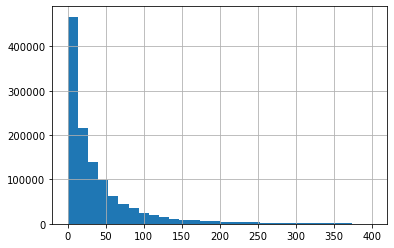

In [6]:
# vendo distribuição dos comentarios letras

df["comment_size"].hist(bins=30, range=[0, 400])
df["comment_size"].quantile(0.95)


In [7]:
# testando algumas variáveis que podem ser úteis
# vendo quem mencionou no comentário algumas coisas que podem ser reclamaçãoe
# ver se o id de usuário ta duplicado e criar váriavel se comentou mais de uma vez
df["comment_with_date"] = df["comment"].apply(
    lambda x: re.findall(r"(\d+/\d+/\d+)", str(x))
)
df["comment_with_specific_hour"] = df["comment"].apply(
    lambda x: re.findall(r"(\d+:\d\d)", str(x))
)
df["comment_mentions_hour"] = df["comment"].apply(
    lambda x: re.findall(r"\bhoras?\b", str(x))
)
df["comment_mentions_day"] = df["comment"].apply(
    lambda x: re.findall(r"\bdias?\b", str(x))
)

df["comment_number_of_dates"] = df["comment_with_date"].apply(len)
df["comment_number_day"] = df["comment_mentions_day"].apply(len)
df["comment_number_hour"] = df["comment_mentions_hour"].apply(len)
df["comment_number_specific_hour"] = df["comment_with_specific_hour"].apply(len)


In [16]:
# text preprocessing helper functions
stopwords_pt = stopwords.words("portuguese")
stopwords_pt.pop(12)  # tirando 'não'
print(stopwords_pt)
spell = Speller("pt", fast=True)


def clean_text(text):
    """Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers."""
    text = text.lower()
    text = re.sub("\[.*?\]", "", text)
    text = re.sub("https?://\S+|www\.\S+", "", text)
    text = re.sub("<.*?>+", "", text)
    # add_space_after_punctuation,
    # str(text)) # adiciona espaço se pontuação não seguida de espaço para não misturar
    text = re.sub("[%s]" % re.escape(string.punctuation), "", text)
    # string punctuation will give the all sets of punctuation.
    text = re.sub("\n", "", text)
    text = re.sub("\w*\d\w*", "", text)
    return text


def text_spell_check(text):
    corrected_text = spell(text)
    return corrected_text


def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r"\w+")
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    remove_stopwords = [w for w in tokenized_text if w not in stopwords_pt]
    combined_text = " ".join(remove_stopwords)
    return combined_text


['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em', 'um', 'para', 'com', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'ao', 'ele', 'das', 'à', 'seu', 'sua', 'ou', 'quando', 'muito', 'nos', 'já', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo', 'aos', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'você', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'numa', 'pelos', 'elas', 'qual', 'nós', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos', 'estivessem', 'estiver', 'estivermos',

In [69]:
if os.path.exists(f"../data/transformed/comments_clean.csv"):
    df = pd.read_csv(f"../data/transformed/comments_clean.csv")
else:
    # Applying the cleaning function
    df["comment_clean"] = (
        df["comment"].apply(str).apply(lambda x: text_preprocessing(x))
    )
    df["clean_comment_word_count"] = df["comment_clean"].apply(
        lambda x: len(str(x).split())
    )

    df.loc[df.index == 138502].to_excel(f"../teste.xlsx")
    df.to_csv(f"../data/transformed/comments_clean.csv")


In [70]:
df.sample(10)[["comment", "comment_clean"]]


,comment,comment_clean
177524,Ótimo aplicativo 💋,ótimo aplicativo
555471,simples e é bom,simples bom
299539,Muito bom,bom
1157206,Eficiente,eficiente
414810,Eu achei super ótimo pois eu consegui ter aces...,achei super ótimo pois consegui ter acesso tod...
489739,Excelente aplicativo,excelente aplicativo
887548,Me serve bem aos meus propósitos,serve bem propósitos
441529,"Depois de 10 anos se conta, vcs extraviaram um...",anos conta vcs extraviaram cartão alguém compr...
833977,Banco do Brasil dando show!,banco brasil dando show
912363,"App muito útil, economiza tempo.",app útil economiza tempo


72.0
478
120


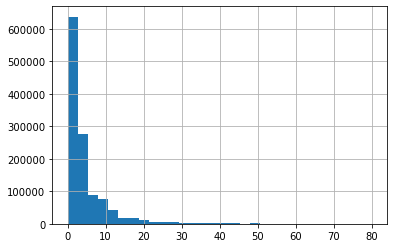

In [71]:
# vendo distribuição dos comentarios palavras

df["clean_comment_word_count"].hist(bins=30, range=[0, 80])
print(df["clean_comment_word_count"].quantile(0.9999))
print(df["clean_comment_word_count"].max())
print(round(len(df) - 0.9999 * len(df)))


442080


<AxesSubplot:>

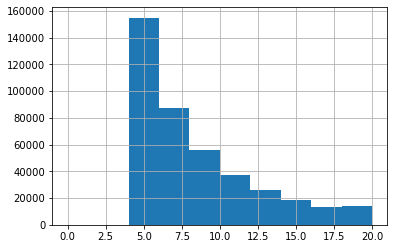

In [113]:
# * selecionando comentários limpos que contém menos que 4 palavras ou mais \
# * palavras que 99.99% dos outros

filtro1 = (
    df["clean_comment_word_count"]
    < df["clean_comment_word_count"].quantile(0.9999) + 2
)
df_clean_save = df.loc[filtro1]

filtro2 = df_clean_save["clean_comment_word_count"] > 3

df_clean_save = df_clean_save.loc[filtro2]

print(len(df_clean_save))
df_clean_save["clean_comment_word_count"].hist(bins=10, range=[0, 20])


In [114]:
df_clean_save.to_csv(
    f"../data/transformed/comments_clean_sem_pequenos_e_grande.csv"
)
